# MAT dSTRF twin experiment

This script runs a twin experiment with a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, mat, dstrf_mat

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Setting paramters and loading data

In [2]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 15
coslin = 10
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]

## Simulating data for the twin experiment

### Building the STRF

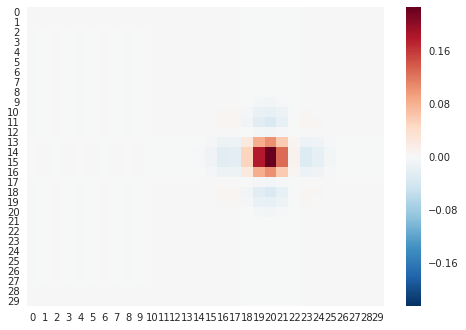

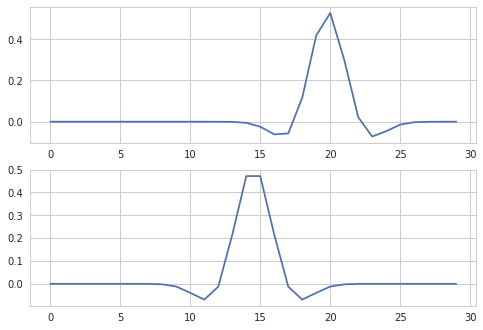

In [3]:
#Construct the filter
sres = nspec - 1 #resolution of the filter in pixels
tres = tlen      #time window of the filter in ms
maxfreq = 8000   #maximum frequency of the signal
latency = 50     #offset between stimulus and response in ms (range: 0 to time)
frequency = 4000 #centering frequency for the filter
A = 0.25         #amplitude of the wavelet peak -- probably don't need to change this
sigma = 0.05 #width of the filter in the time axis -- bigger sigma = narrower time band
gamma = 0.0015   #width of the filter in the frequency axis -- bigger gamma = narrower frequency band
alpha = 1        #depth of inhibitory sidebands on time axis -- bigger alpha = deeper sidebands
beta = 1         #depth of inhibitory sidebands on frequency axis -- bigger beta = deeper sidebands

#ss.strf returns three arguments: h is the strf, t and f are correctly labeled axes for plotting
k, t, f = utils.strf(sres,150,maxfreq,latency,frequency,A,sigma,gamma,alpha,beta)

k = resample(k,tres,axis=1)
#k = nfutils.normalize(k,center=False)

figure()
sns.heatmap(k,linewidths = 0)

figure()
B = np.sum(k,axis=1)
A = np.sum(k,axis=0)
subplot(211)
plot(A)
subplot(212)
plot(B)

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True)
costim = tot(tim)
 
# set MAT model parameters
matparam  = [10,2,0,8]
#matparam  = [20,2,0,25]

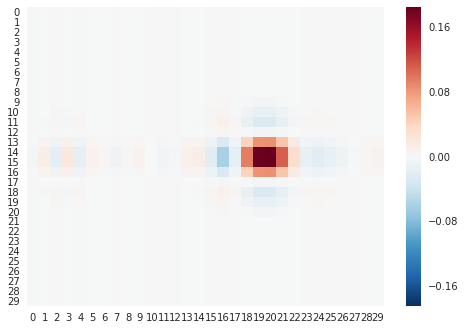

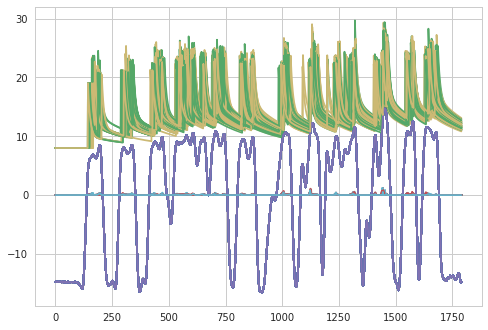

In [4]:
dataparam = np.hstack((spec[0],costim[0],matparam))
M = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center,stochastic=True)
M.set(dataparam)
figure()
sns.heatmap(M.pstrf.filt)

figure()
for i in range(100):
    plot(M.run(stims[0])[0])

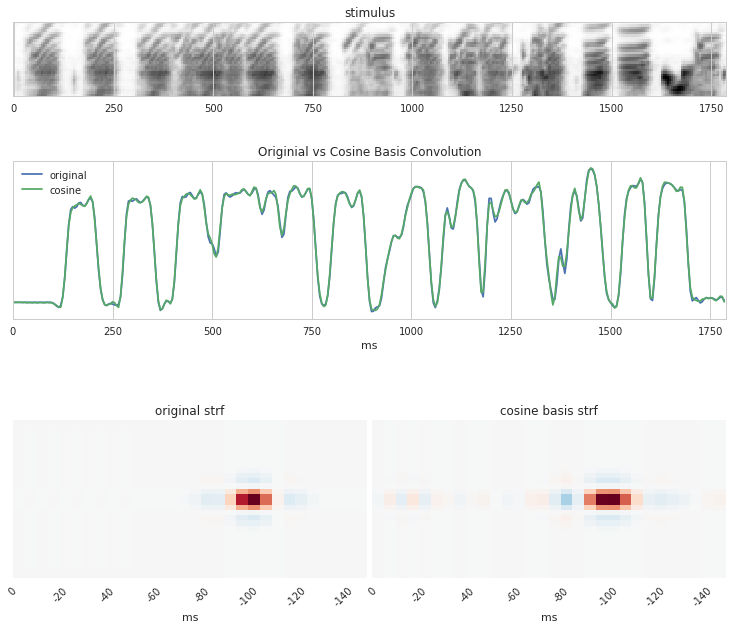

In [5]:
figure(figsize=(10,10))
subplot2grid((6,2),(1,0),1,2)
imshow(stims[0],aspect="auto")
xticks(range(0,351,50),np.arange(0,351*t_dsample,50*t_dsample))
yticks([])
title("stimulus")

subplot2grid((3,2),(1,0),1,2)
plot(utils.spgconv(k,stims[0]),label="original")
plot(utils.spgconv(M.pstrf.filt,stims[0]),label="cosine")
legend(loc="upper left")
title("Originial vs Cosine Basis Convolution")
yticks([])
xticks(range(0,351,50),np.arange(0,351*t_dsample,50*t_dsample))
xlabel("ms")
xlim((0,len(stims[0].T)))

subplot2grid((3,2),(2,0))
sns.heatmap(k,cbar=False)
title("original strf")
xticks(np.arange(0,30,4),map(lambda x: -x, np.arange(0,150,20)),rotation=45)
xlabel("ms")
yticks([])

subplot2grid((3,2),(2,1))
sns.heatmap(M.pstrf.filt,cbar=False)
title("cosine basis strf")
xticks(np.arange(0,30,4),map(lambda x: -x, np.arange(0,150,20)),rotation=45)
xlabel("ms")
yticks([])

tight_layout(pad=0)

### Generating noisy data

In [6]:
# data settings
ntrials = 5
noise = 0.25
dataparam = np.hstack((spec[0],costim[0],matparam))
M = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,noise=noise,normalize=norm,center=center)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    dsdur = int(dur/t_dsample)
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=t_dsample) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.76
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 894 µs per loop


## Getting initial guess for STRF

In [8]:
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.624350107377


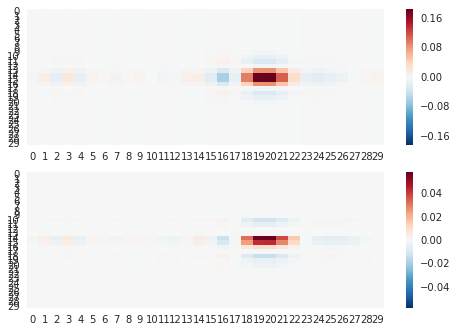

In [9]:
# plot true and estimated strf
subplot(211)
sns.heatmap(M.pstrf.filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [7]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

cost = spike_distance
unbounded = priors.unbounded()

def l1_prior(theta):
    return -np.sum(np.abs(theta))

def dstrf_prior(theta):
    return l1_prior(theta[:-4]) + mat_prior(theta[-4:])

## Run initial MAT parameter fit

In [ ]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[5,0,0,1],[0.1]*4)
#p0 = startpos.normal_independent(nwalkers,matparam,[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),threads)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -1697.3     0:00:47     0:07:13
   200     -1622.4     0:01:31     0:06:06
   300     -1617.6     0:02:14     0:05:14
   400     -1615.5     0:02:57     0:04:27
   500     -1614.3     0:03:41     0:03:42
   600     -1613.4     0:04:24     0:02:56
   700     -1612.6     0:05:07     0:02:12


In [16]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

Filt R: 0.627, MAT R: 0.794


## Fit dSTRF model using emcee

In [ ]:
# initalize the model
model = dstrf_mat(channels,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
#p01 = startpos.normal_independent(nwalkers,filt_start,[1e-1]*len(start))
#p02 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))
#p0 = np.hstack((p0,mat_smplr.chain[:-1,0,:]))
#p0 = np.hstack((p01,p02))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),threads)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -3097.2     0:06:21     0:57:51
   200     -2855.8     0:12:08     0:48:53
   300     -2764.4     0:17:51     0:41:52


## Evaluate the model fit

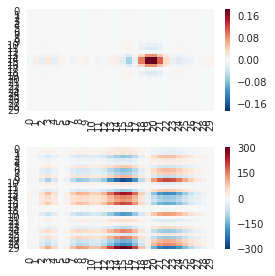

In [25]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,)

subplot(212)
sns.heatmap(model.pstrf.filt)
tight_layout()

In [26]:
map_corr, map_psths = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr, pp_psths = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
#print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.57, Dist: 0.41, EO: 0.84
